# Analyse de données Budget et Finances

## Paramétrage

In [1]:
import os

import pandas as pd
CHEMIN_DOSSIER_DONNÉES = '../../../../données/DIAMANT'
DATE_FICHIER = '2022_09_01'
encoding = 'utf-8'


In [2]:
ann_per_errd_eprd = pd.read_csv(
    os.path.join(CHEMIN_DOSSIER_DONNÉES, 'ANN_PER_ERRD_EPRD_' + DATE_FICHIER + '.CSV'),
    delimiter=";",
    encoding=encoding,
    dtype='str'
)

## Doublons

### On s'attend à avoir une seule valeur par (Finess, Année, Id Dépôt)

In [3]:
ann_per_errd_eprd.head()

,Finess EJ,Finess,Année,Id Dépôt
0,480782259,480001130,2019,143783
1,130001753,130008568,2020,203489
2,440002426,440003648,2018,126667
3,370000440,370011298,2018,117146
4,060002813,060799491,2020,204473


In [4]:
ann_per_errd_eprd.duplicated(subset=["Finess", "Année", "Id Dépôt"]).sum()

0

On a bien unicité

### A-t-on un seul numéro de dépôt pour un FINESS et une année ?

In [5]:
a_plus_d_une_donnée_par_finess_par_année = (ann_per_errd_eprd[['Finess', 'Année', "Id Dépôt"]].groupby(['Finess', 'Année']).nunique() > 1)

In [6]:
a_plus_d_une_donnée_par_finess_par_année.sum() / ann_per_errd_eprd.groupby(['Finess', 'Année']).ngroups

Id Dépôt    0.929997
dtype: float64

Non : la plupart des établissements ont plusieurs numéros de dépôt pour une même année

<AxesSubplot:title={'center':'Répartition du nombre de dépôts pour un même Finess et année'}, ylabel='Frequency'>

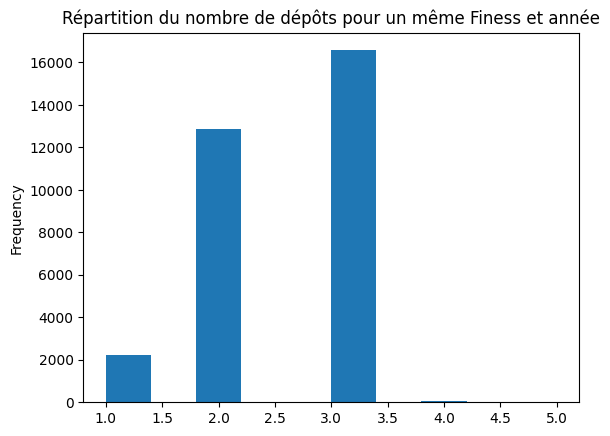

In [7]:
ann_per_errd_eprd[['Finess', 'Année', "Id Dépôt"]].groupby(['Finess', 'Année']).nunique().plot(
    kind= 'hist',
    title="Répartition du nombre de dépôts pour un même Finess et année",
    legend=False,
)

In [8]:
ann_per_errd_eprd[['Finess', 'Année', "Id Dépôt"]].groupby(['Finess', 'Année']).nunique().value_counts().sort_index()

Id Dépôt
1            2221
2           12864
3           16571
4              59
5              12
dtype: int64

La plupart des Finess font l'objet de 2-3 dépots / an

<AxesSubplot:title={'center':'répartition des Finess par année'}, xlabel='Année'>

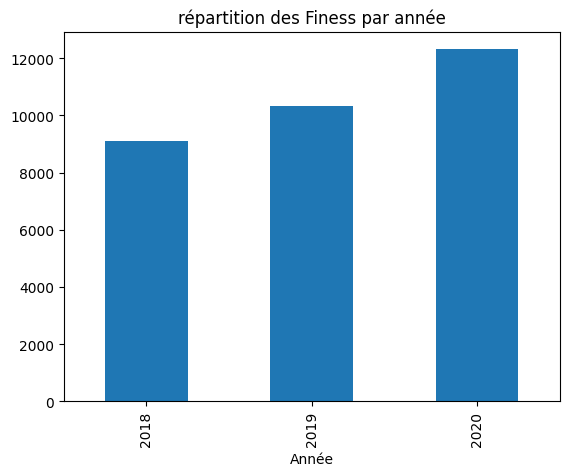

In [9]:
ann_per_errd_eprd.groupby('Année')['Finess'].nunique().plot(kind="bar", title="répartition des Finess par année")

<AxesSubplot:title={'center':'répartition des Finess par année'}, xlabel='Année'>

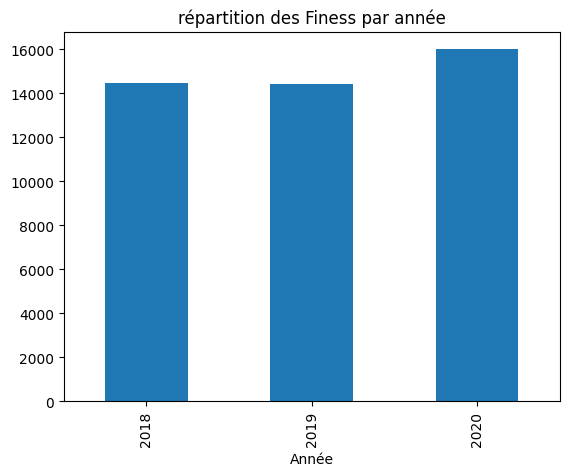

In [10]:
ann_per_errd_eprd.groupby('Année')['Id Dépôt'].nunique().plot(kind="bar", title="répartition des Finess par année")

Le nombre de FINESS renseignés augmente plus que le nombre de dépôts.

## A-t-on des groupements stables ?

Un Id Dépôt correspond à une mise à jour d'un groupement d'ET. Est-ce que ces groupements restent stables, auquel cas on peut facilement dédoublonner nos données ?

In [11]:
groups = ann_per_errd_eprd[['Finess', 'Année', "Id Dépôt"]].groupby(["Id Dépôt", "Année"])['Finess'].apply(set)

In [12]:
unique_groups = groups.sort_index(ascending=False).drop_duplicates()

In [13]:
intersecting_groups = []
for group1 in unique_groups.values:
    for group2 in unique_groups.values:
        if (group1 != group2) and group1.intersection(group2):
            intersecting_groups.append((group1, group2))

In [14]:
len(intersecting_groups) / 2

1649.0

On voit que, dans une même année, les groupes d'ET qui sont déposés ensemble évoluent. Lequel fait foi ? Hypothèse : selon nos discussions, il me semble que c'est le numéro le plus "grand" qui constitue la dernière MàJ dans nos données, et donc qu'on peut prendre le numéro de dépôt le plus grand pour établir le groupement d'établissements.
